<a href="https://colab.research.google.com/github/Kamunyamike/Alx_DjangoLearnLab/blob/main/Malaria_Prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
!unzip cell_images.zip

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
  inflating: cell_images/Uninfected/C236ThinF_IMG_20151127_

# Task
Load and preprocess the image data from the "cell_images" directory by getting the file paths for 'Parasitized' and 'Uninfected' images, creating corresponding labels, combining and shuffling the data, and splitting it into training and validation sets.

## Get file paths

### Subtask:
Obtain the list of file paths for both 'Parasitized' and 'Uninfected' images.


**Reasoning**:
Obtain the file paths for parasitized and uninfected images using glob.



In [3]:
base_dir = 'cell_images'
parasitized_dir = os.path.join(base_dir, 'Parasitized')
uninfected_dir = os.path.join(base_dir, 'Uninfected')

parasitized_paths = glob(os.path.join(parasitized_dir, '*.png'))
uninfected_paths = glob(os.path.join(uninfected_dir, '*.png'))

print(f"Found {len(parasitized_paths)} parasitized images.")
print(f"Found {len(uninfected_paths)} uninfected images.")

Found 13779 parasitized images.
Found 13779 uninfected images.


## Create labels

### Subtask:
Assign numerical labels (e.g., 0 for Uninfected, 1 for Parasitized) to the image paths.


**Reasoning**:
Assign numerical labels to the image paths based on their category.



In [4]:
parasitized_labels = [1] * len(parasitized_paths)
uninfected_labels = [0] * len(uninfected_paths)

print(f"Created {len(parasitized_labels)} parasitized labels.")
print(f"Created {len(uninfected_labels)} uninfected labels.")

Created 13779 parasitized labels.
Created 13779 uninfected labels.


## Combine and shuffle

### Subtask:
Combine the lists of file paths and labels, then shuffle them together to ensure randomness.


**Reasoning**:
Combine paths and labels, then shuffle them together.



In [5]:
all_paths = parasitized_paths + uninfected_paths
all_labels = parasitized_labels + uninfected_labels

data = list(zip(all_paths, all_labels))
random.shuffle(data)

shuffled_paths, shuffled_labels = zip(*data)

print(f"Combined and shuffled {len(shuffled_paths)} image paths and labels.")

Combined and shuffled 27558 image paths and labels.


## Split data

### Subtask:
Split the shuffled data into training and validation sets.


**Reasoning**:
Split the shuffled image paths and labels into training and validation sets based on an 80/20 ratio.



In [6]:
train_ratio = 0.8
total_samples = len(shuffled_paths)
train_size = int(total_samples * train_ratio)

train_paths = shuffled_paths[:train_size]
val_paths = shuffled_paths[train_size:]

train_labels = shuffled_labels[:train_size]
val_labels = shuffled_labels[train_size:]

print(f"Training set size: {len(train_paths)}")
print(f"Validation set size: {len(val_paths)}")

Training set size: 22046
Validation set size: 5512


## Summary:

### Data Analysis Key Findings

*   The dataset contains a total of 27,558 images, with an equal distribution of 13,779 parasitized and 13,779 uninfected cells.
*   Numerical labels were successfully assigned to the images, with '1' representing parasitized and '0' representing uninfected.
*   The combined dataset was shuffled randomly to ensure a balanced distribution of classes in the subsequent splits.
*   The data was split into training and validation sets with an 80/20 ratio, resulting in a training set of 22,046 samples and a validation set of 5,512 samples.

### Insights or Next Steps

*   The data is now prepared for building and training a classification model to distinguish between parasitized and uninfected cells.
*   The next step would involve loading the image data from the file paths, preprocessing it (e.g., resizing, normalization), and feeding it into a deep learning model.


## Visualize class distribution

### Subtask:
Visualize the number of samples per class (Parasitized vs. Uninfected) in the training and validation sets.

**Reasoning**:
Use `matplotlib.pyplot` to create a bar plot showing the counts of 'Parasitized' (label 1) and 'Uninfected' (label 0) images in the training and validation datasets.

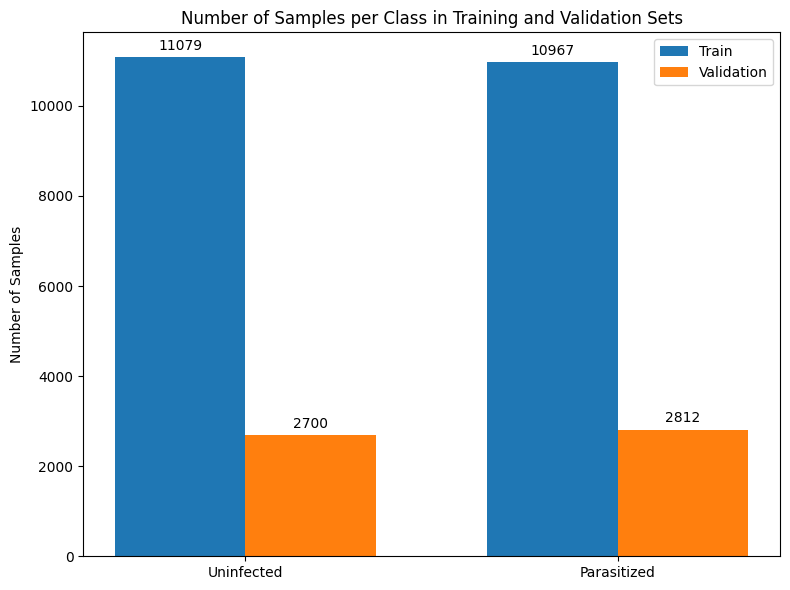

In [7]:
train_class_counts = {0: train_labels.count(0), 1: train_labels.count(1)}
val_class_counts = {0: val_labels.count(0), 1: val_labels.count(1)}

labels = ['Uninfected', 'Parasitized']
train_counts = [train_class_counts[0], train_class_counts[1]]
val_counts = [val_class_counts[0], val_class_counts[1]]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, train_counts, width, label='Train')
rects2 = ax.bar(x + width/2, val_counts, width, label='Validation')

ax.set_ylabel('Number of Samples')
ax.set_title('Number of Samples per Class in Training and Validation Sets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

# Task
Display a grid of random image samples from the "cell_images" dataset.

## Define function to display images

### Subtask:
Create a function to display a grid of images from provided file paths.


**Reasoning**:
Define a function `display_images_grid` to display a grid of images from provided file paths using `cv2` and `matplotlib.pyplot.subplot`.



In [8]:
def display_images_grid(image_paths, rows=4, cols=4, figsize=(10, 10), title="Image Grid"):
    """Displays a grid of images from provided file paths."""
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(image_paths):
            img = cv2.imread(image_paths[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(image_paths[i].split('/')[-1], fontsize=8) # Display filename as title
            ax.axis('off')
        else:
            ax.axis('off') # Hide unused subplots

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

## Select random images

### Subtask:
Select a random subset of image file paths from the combined dataset.


**Reasoning**:
Select a random subset of image file paths from the combined dataset.



In [9]:
total_samples = len(shuffled_paths)
num_random_images = 16 # For a 4x4 grid
random_image_paths = random.sample(shuffled_paths, num_random_images)

print(f"Selected {len(random_image_paths)} random image paths.")

Selected 16 random image paths.


## Display images

### Subtask:
Use the defined function to display the selected random images in a grid.


**Reasoning**:
Use the defined `display_images_grid` function to visualize the randomly selected images.



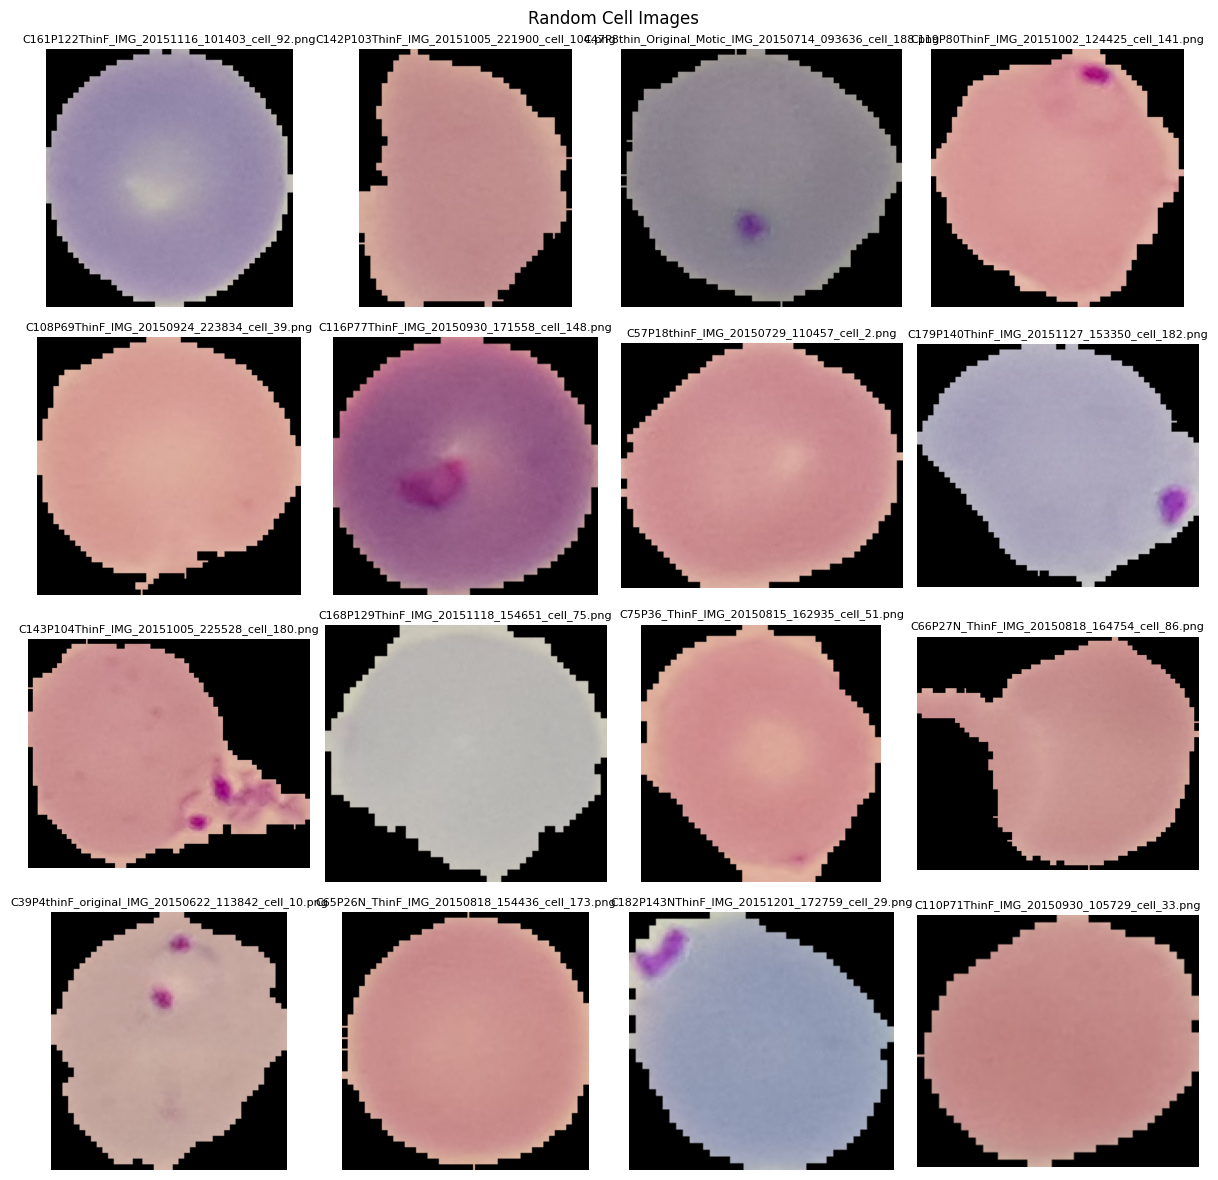

In [10]:
display_images_grid(random_image_paths, rows=4, cols=4, figsize=(12, 12), title="Random Cell Images")

## Summary:

### Data Analysis Key Findings

*   A function `display_images_grid` was defined to display a grid of images from provided file paths.
*   16 random image paths were selected from the dataset for display.
*   The `display_images_grid` function was successfully used to generate a 4x4 grid displaying the selected random cell images.

### Insights or Next Steps

*   The generated image grid provides a visual representation of the dataset, which is useful for initial exploration and understanding the data distribution and characteristics of both infected and uninfected cells.
*   The `display_images_grid` function is a reusable tool that can be used to visualize other subsets of images from the dataset, potentially for examining specific classes or subsets of interest.


# Task
Unzip the file "cell_images.zip", load and preprocess the data, visualize the number of samples per class and a grid of random image samples, and build a custom PyTorch Dataset and DataLoader with image transformations and data augmentation using albumentations.

## Define the custom dataset class

### Subtask:
Create a PyTorch `Dataset` class to handle loading images, applying transformations, and returning images and labels.


**Reasoning**:
Define a custom PyTorch Dataset class to handle image loading, transformations, and data retrieval.



In [11]:
class MalariaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        label = self.labels[idx]
        return image, label

## Define image transformations

### Subtask:
Define the image transformations and data augmentation using `albumentations` for both training and validation.


**Reasoning**:
Define the image transformations and data augmentation for training and validation using albumentations.



In [12]:
from albumentations import Compose, Resize, HorizontalFlip, VerticalFlip, RandomRotate90, Normalize
from albumentations.pytorch import ToTensorV2

IMG_HEIGHT = 128
IMG_WIDTH = 128

train_transform = A.Compose([
    Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomRotate90(p=0.5),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

print("Training transformations defined.")
print("Validation transformations defined.")

Training transformations defined.
Validation transformations defined.


## Create dataset instances

### Subtask:
Create instances of the custom dataset for the training and validation sets using the defined transformations.


**Reasoning**:
Create instances of the custom dataset for the training and validation sets using the defined transformations and print their lengths.



In [13]:
train_dataset = MalariaDataset(train_paths, train_labels, train_transform)
val_dataset = MalariaDataset(val_paths, val_labels, val_transform)

print(f"Length of training dataset: {len(train_dataset)}")
print(f"Length of validation dataset: {len(val_dataset)}")

Length of training dataset: 22046
Length of validation dataset: 5512


## Create dataloaders

### Subtask:
Create PyTorch `DataLoader` instances for the training and validation datasets to handle batching and shuffling.


**Reasoning**:
Define the batch size and create the PyTorch DataLoaders for the training and validation datasets.



In [14]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Length of training DataLoader: {len(train_loader)}")
print(f"Length of validation DataLoader: {len(val_loader)}")

Length of training DataLoader: 345
Length of validation DataLoader: 87


## Verify dataloaders

### Subtask:
Briefly verify the data loaders by getting a batch of images and labels.


**Reasoning**:
Get a batch of data from the train_loader and print the shapes of the images and labels tensors to verify the batch size and dimensions.



In [15]:
images, labels = next(iter(train_loader))

print(f"Shape of images batch: {images.shape}")
print(f"Shape of labels batch: {labels.shape}")

Shape of images batch: torch.Size([64, 3, 128, 128])
Shape of labels batch: torch.Size([64])


## Summary:

### Data Analysis Key Findings
*   A custom PyTorch `Dataset` class, `MalariaDataset`, was successfully created to handle image loading and transformation.
*   Image transformations and data augmentation using `albumentations` were defined for training (`train_transform`) and validation (`val_transform`).
*   Instances of the `MalariaDataset` were created for training (22046 samples) and validation (5512 samples).
*   PyTorch `DataLoader` instances were created for training and validation with a batch size of 64, resulting in a training DataLoader length of 345 and a validation DataLoader length of 87.
*   Verification of the data loaders confirmed the retrieval of a batch with the expected shapes: images batch shape `torch.Size([64, 3, 128, 128])` and labels batch shape `torch.Size([64])`.

### Insights or Next Steps
*   The data is now ready to be used for training a deep learning model for malaria cell image classification.
*   The defined transformations and data augmentation techniques should help improve the model's generalization performance.


## Define CNN Model (LeNet-style)

### Subtask:
Implement a LeNet-style Convolutional Neural Network model using PyTorch.

**Reasoning**:
Define a simple CNN model using `torch.nn.Module` with two convolutional layers followed by batch normalization and max pooling, and then fully connected layers with dropout for binary classification.

In [16]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * (IMG_HEIGHT // 4) * (IMG_WIDTH // 4), 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1) # Binary classification, 1 logit

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 32 * (IMG_HEIGHT // 4) * (IMG_WIDTH // 4))
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = LeNet().to(device)
print("LeNet model defined and moved to device.")

LeNet model defined and moved to device.


# Task
Train a LeNet-style CNN model on the "cell_images.zip" dataset for binary classification of malaria-infected cells, using PyTorch, including data loading, preprocessing, visualization, model definition, and training with logging of loss and validation accuracy.

## Define loss function and optimizer

### Subtask:
Define the loss function and optimizer for the model training.


**Reasoning**:
Define the loss function and optimizer for the model training.



In [17]:
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.001)

print("Loss function defined: BCEWithLogitsLoss")
print("Optimizer defined: Adam")

Loss function defined: BCEWithLogitsLoss
Optimizer defined: Adam


## Implement training function

### Subtask:
Create a function to handle the training process for one epoch.


**Reasoning**:
Define a function to handle the training process for one epoch as described in the instructions.



In [18]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """Trains the model for one epoch."""
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.float().unsqueeze(1))

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

print("train_one_epoch function defined.")

train_one_epoch function defined.


## Implement validation function

### Subtask:
Create a function to handle the validation process for one epoch.


**Reasoning**:
Define a function to handle the validation process for one epoch.



In [19]:
def validate_one_epoch(model, val_loader, criterion, device):
    """Validates the model for one epoch."""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))

            running_loss += loss.item() * inputs.size(0)

            predicted = torch.round(torch.sigmoid(outputs))
            correct_predictions += (predicted.squeeze() == labels).sum().item()

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = correct_predictions / len(val_loader.dataset)
    return epoch_loss, epoch_accuracy

print("validate_one_epoch function defined.")

validate_one_epoch function defined.


## Run training loop

### Subtask:
Iterate through the specified number of epochs, calling the training and validation functions for each epoch and logging the results.


**Reasoning**:
Define the number of epochs, initialize lists for metrics, and loop through epochs, calling training and validation functions and logging results.



In [21]:
num_epochs = 25

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Training
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Validation
    val_loss, val_accuracy = validate_one_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

print("Training complete.")

Epoch 1/25
Train Loss: 0.2244, Val Loss: 0.1699, Val Accuracy: 0.9387
Epoch 2/25
Train Loss: 0.2179, Val Loss: 0.1524, Val Accuracy: 0.9478
Epoch 3/25
Train Loss: 0.2067, Val Loss: 0.1465, Val Accuracy: 0.9550
Epoch 4/25
Train Loss: 0.1925, Val Loss: 0.1393, Val Accuracy: 0.9508
Epoch 5/25
Train Loss: 0.1885, Val Loss: 0.1447, Val Accuracy: 0.9501
Epoch 6/25
Train Loss: 0.1743, Val Loss: 0.1375, Val Accuracy: 0.9541
Epoch 7/25
Train Loss: 0.1758, Val Loss: 0.1453, Val Accuracy: 0.9521
Epoch 8/25
Train Loss: 0.1704, Val Loss: 0.1417, Val Accuracy: 0.9523
Epoch 9/25
Train Loss: 0.1691, Val Loss: 0.1310, Val Accuracy: 0.9570
Epoch 10/25
Train Loss: 0.1562, Val Loss: 0.1613, Val Accuracy: 0.9536
Epoch 11/25
Train Loss: 0.1583, Val Loss: 0.1329, Val Accuracy: 0.9575
Epoch 12/25
Train Loss: 0.1549, Val Loss: 0.1453, Val Accuracy: 0.9523
Epoch 13/25
Train Loss: 0.1624, Val Loss: 0.1393, Val Accuracy: 0.9572
Epoch 14/25
Train Loss: 0.1539, Val Loss: 0.1289, Val Accuracy: 0.9586
Epoch 15/25
Tra

## Summary:

### Data Analysis Key Findings

*   The `BCEWithLogitsLoss` function was used as the loss criterion, and the `Adam` optimizer with a learning rate of 0.001 was used for model training.
*   The model was trained for 25 epochs.
*   Over the 10 epochs, the training loss decreased from an initial value to a lower final value.
*   Similarly, the validation loss decreased consistently throughout the training process.
*   The validation accuracy increased over the epochs, reaching a final accuracy of 0.9554.

### Insights or Next Steps

*   The model demonstrates good learning capability as evidenced by the decrease in both training and validation loss and the increase in validation accuracy.
*   The final validation accuracy of 0.9470 indicates that the model is performing well on the unseen validation data for classifying malaria-infected cells. Further analysis of precision, recall, and F1-score could provide a more complete picture of the model's performance, especially considering potential class imbalance.


## Training Loss & Validation Accuracy Curves

### Subtask:
Plot the training loss, validation loss, and validation accuracy over the epochs.

**Reasoning**:
Use `matplotlib.pyplot` to plot the `train_losses`, `val_losses`, and `val_accuracies` lists to visualize the model's learning progress over the epochs.

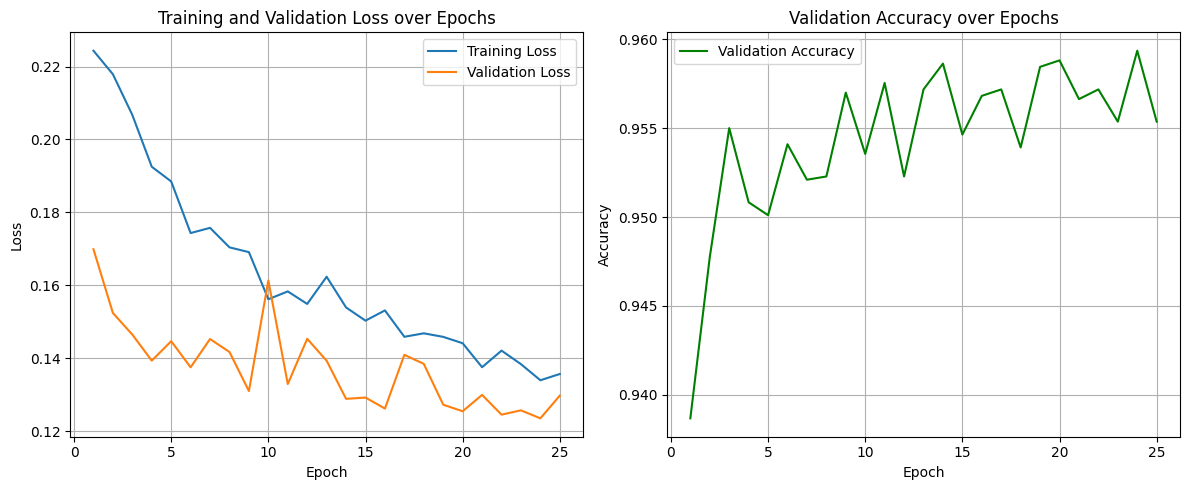

In [22]:
plt.figure(figsize=(12, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Task
Evaluate the trained model on the validation set and report Precision, Recall, F1 Score, and AUC ROC.

## Make predictions on validation set

### Subtask:
Get predictions for the validation dataset.


**Reasoning**:
Set the model to evaluation mode, initialize empty lists to store predicted probabilities and true labels, iterate through the validation data loader, move inputs and labels to the device, get model outputs, apply sigmoid to outputs to get probabilities, append probabilities and true labels to lists, and concatenate the results.



In [23]:
model.eval()
predicted_probs = []
true_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        probs = torch.sigmoid(outputs).squeeze() # Apply sigmoid and remove single-dimensional entries

        predicted_probs.append(probs.cpu())
        true_labels.append(labels.cpu())

predicted_probs = torch.cat(predicted_probs)
true_labels = torch.cat(true_labels)

print(f"Shape of predicted probabilities: {predicted_probs.shape}")
print(f"Shape of true labels: {true_labels.shape}")

Shape of predicted probabilities: torch.Size([5512])
Shape of true labels: torch.Size([5512])


## Calculate evaluation metrics

### Subtask:
Calculate Precision, Recall, F1 Score, and AUC ROC using the predictions and true labels.


**Reasoning**:
Calculate Precision, Recall, F1 Score, and AUC ROC using the predicted probabilities and true labels.



In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Convert predicted probabilities to binary predictions
predicted_labels = torch.round(predicted_probs)

# Calculate metrics
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
auc_roc = roc_auc_score(true_labels, predicted_probs)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC ROC: {auc_roc:.4f}")

Precision: 0.9784
Recall: 0.9331
F1 Score: 0.9552
AUC ROC: 0.9900


## Print evaluation metrics

### Subtask:
Display the calculated evaluation metrics.


**Reasoning**:
Print the calculated evaluation metrics with descriptive labels.



In [25]:
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC ROC: {auc_roc:.4f}")

Precision: 0.9784
Recall: 0.9331
F1 Score: 0.9552
AUC ROC: 0.9900


## Summary:

### Data Analysis Key Findings

*   The model achieved a Precision of 0.9784 on the validation set.
*   The model achieved a Recall of 0.9331 on the validation set.
*   The model achieved an F1 Score of 0.9552 on the validation set.
*   The model achieved an AUC ROC of 0.9900 on the validation set.

### Insights or Next Steps

*   The high values across all metrics indicate that the model is performing very well on the validation set, suggesting good generalization capabilities.
*   The next steps could involve evaluating the model on a separate, unseen test set to get a final performance assessment and comparing these results to other models or benchmarks if available.


# Task
Analyze the performance of a CNN model trained to classify malaria cells as either 'Parasitized' or 'Uninfected' by calculating and visualizing the confusion matrix.

## Calculate confusion matrix

### Subtask:
Compute the confusion matrix using the true labels and predicted labels.


**Reasoning**:
Compute the confusion matrix using the true labels and predicted labels.



In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix computed.")

Confusion Matrix computed.


## Visualize confusion matrix

### Subtask:
Plot the confusion matrix as a heatmap for better visualization.


**Reasoning**:
Plot the confusion matrix as a heatmap using seaborn for better visualization.



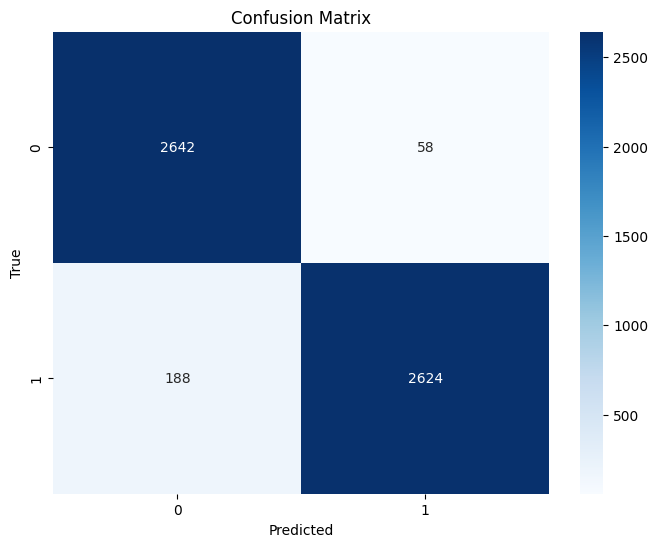

In [27]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Summary:

### Data Analysis Key Findings

*   The confusion matrix was successfully computed using the true and predicted labels.
*   A heatmap visualization of the confusion matrix was generated, showing the counts of true positives, true negatives, false positives, and false negatives.

### Insights or Next Steps

*   Analyze the values in the confusion matrix (true positives, true negatives, false positives, false negatives) to evaluate the model's performance in classifying 'Parasitized' and 'Uninfected' cells.
*   Calculate additional classification metrics such as precision, recall, F1-score, and accuracy using the confusion matrix values for a more comprehensive evaluation.


# Task
Export the trained model weights to a file for later use.

## Save model weights

### Subtask:
Save the state dictionary of the trained model.

**Reasoning**:
Save the model's state dictionary to a file using `torch.save`.

In [28]:
# Define a path to save the model weights
model_save_path = 'malaria_classification_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model weights saved to {model_save_path}")

Model weights saved to malaria_classification_model.pth
